<a href="https://colab.research.google.com/github/NRHartFRC/LSTM-Modeling/blob/main/Long_Short_Term_Memory_Market_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Long Short Term Memory AI Modeling with Keras (TensorFlow API)

#### **Description:** this program will attempt to predict the expected price for the following day using Long Short Term Memory method provided by Keras sequential API for deep learning applications. The program captures a dataset for a given `tag` or ticker symbol from Yahoo Finance API (from a specified `start` and `end` date), trains model using a generational neural network on the given dataset, then outputs both a plot, and the predicted output price for the following day.

**Author Information:**
- **Name:** Nicholas Rombach
- **GitHub:** [NRHartFRC](https://github.com/nrhartfrc)


## **License**
<a rel="license" href="https://choosealicense.com/licenses/gpl-3.0/"><img alt="Creative Commons License" style="border-width:0" src="https://www.gnu.org/graphics/gplv3-with-text-136x68.png" /></a><br />This work is licensed under a <a rel="license" href="https://choosealicense.com/licenses/gpl-3.0/">GNU General Public License v3.0</a>

# **Configuration**

Optionals

In [ ]:
#!pip show pandas_datareader
#!pip install --upgrade pandas_datareader
#!pip install pycryptodome pycryptodomex

Required (Run once)

In [ ]:

#!pip uninstall --yes pandas-datareader
#!pip install --upgrade pycryptodome pycryptodomex
#!pip install git+https://github.com/raphi6/pandas-datareader.git@ea66d6b981554f9d0262038aef2106dda7138316 #modified pandas-datareader daily.py to decrypt AES output
#!pip install yfinance

## Imports, depenencies and libraries

In [ ]:
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, DateFormatter  # Import DayLocator and DateFormatter
import math
from datetime import datetime, timedelta

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
plt.style.use('fivethirtyeight')
#pdr.__version__

## User Entered Data

1.   `tag` = ticker, or sybol for equity, stock, ETF, crypto, etc.
2.   `start` = start date in the format YYYY-MM-DD
3.   `end` = end date in the format YYYY-MM-DD (use one day ahead)
4.   `batch_size` = number of iterations per epochs (generations)
5.   `epochs` = number of genarations in the sequential learning model


In [ ]:
tag = 'JOBY'
start = '2023-02-04'
end = '2023-09-18'
batch_size=32 #was 32
epochs=10 #was 10

In [ ]:
# native end date
entered_end = end

# Convert 'end' to a datetime object
end_date = datetime.strptime(end, '%Y-%m-%d')

# Add one day to 'end_date'
end_date += timedelta(days=1)

# Convert 'end_date' back to a string in the 'YYYY-MM-DD' format
end = end_date.strftime('%Y-%m-%d')

print("The actual start date for the model is:", end) # adds a day for yFinance offeset reasons

The actual start date for the model is: 2023-09-19


In [ ]:
# return quote
quote_df = pdr.DataReader(tag,start,end)
quote_df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-02-06,4.65,4.670,4.390,4.42,4.42,3110200
2023-02-07,4.46,4.480,4.210,4.42,4.42,2898700
2023-02-08,4.38,4.440,4.305,4.36,4.36,1875300
2023-02-09,4.47,4.575,4.210,4.22,4.22,2250200
2023-02-10,4.21,4.219,4.095,4.20,4.20,1599400
...,...,...,...,...,...,...
2023-09-12,7.20,7.310,6.980,6.99,6.99,3565600
2023-09-13,6.96,7.045,6.870,6.88,6.88,4684700
2023-09-14,6.90,7.000,6.780,6.94,6.94,4972100


## Display price chart

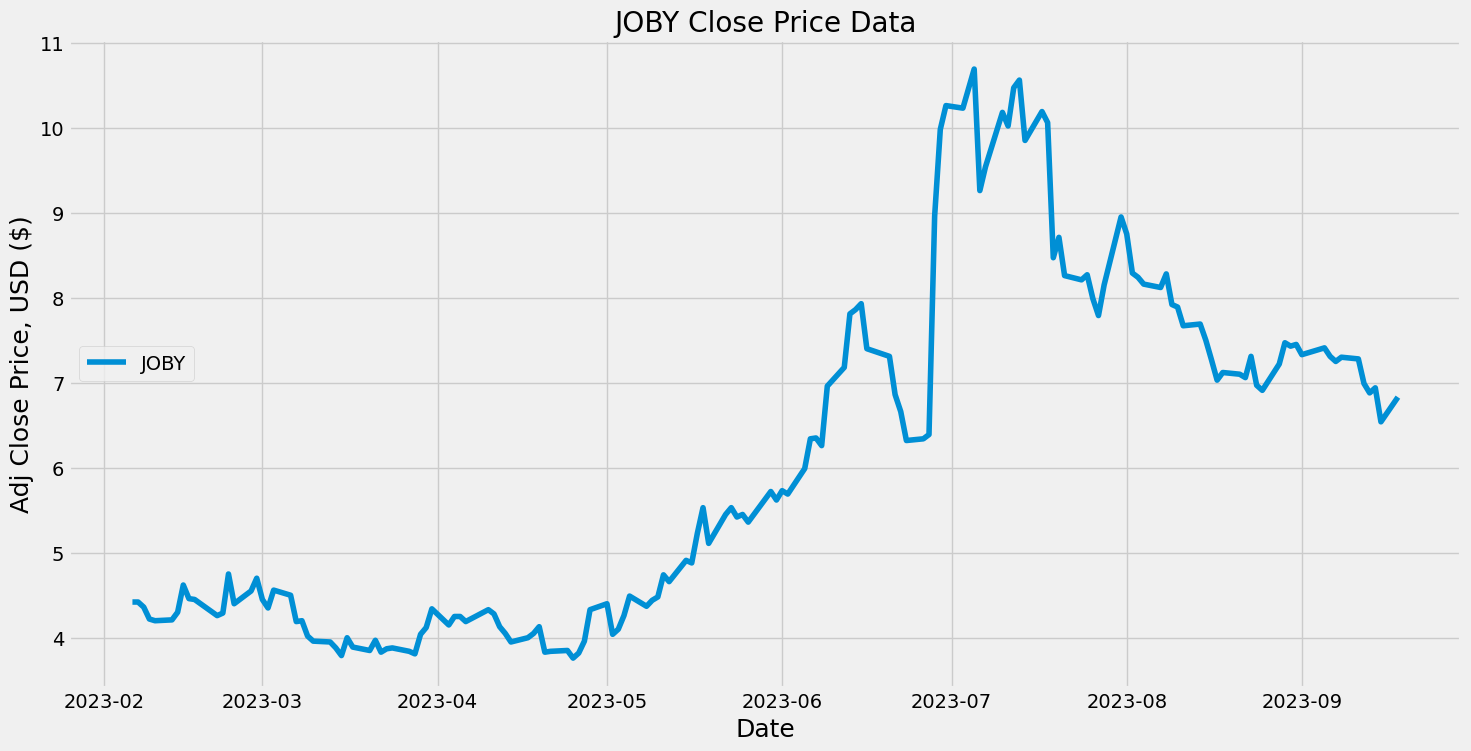

In [ ]:
# show graphic
plt.figure(figsize=(16,8))
plt.title('%s Close Price Data'%str(tag)) # was Close
plt.xlabel('Date', fontsize=18)
plt.ylabel("Adj Close Price, USD ($)", fontsize=18) # was Close
#plt.ylabel('Ten Tenthouthand Volume')
plt.plot(quote_df['Adj Close'], label=str(tag)) # was 'Close'
#plt.plot(quote_df['Volume']*0.000000003, 'r') #10th, micro volume
plt.legend(loc='center left')

### filter stock quote exchange sheet for close prices to array

In [ ]:
data = quote_df.filter(['Adj Close']) # was Close

# convert to np array
array = np.array(data)

### get number of rows to train model

In [ ]:
trainlen = math.ceil((len(array)*0.8))
trainlen

124

### scale data for preprocessing transormations to input data

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1)) #inclusive
scaleddata = scaler.fit_transform(array)
#scaleddata

### create data set for training model

In [ ]:
traindata = scaleddata[0:trainlen,:] # native = traindata = scaleddata[0:trainlen,:]
#traindata

### split traindata into xtrain (as-modeled input history) and ytrain (value to predict)

In [ ]:
xtrain = []
ytrain = []

for i in range(60,len(traindata)): #was 60,len(traindata)
  xtrain.append(traindata[i-60:i,0]) #was i-60:i,0
  ytrain.append(traindata[i,0])
  #if i <=61:
  #  print(xtrain)
  #  print(ytrain)
  #  print()

### convert xtrain and ytrain into np array

In [ ]:
xtrain, ytrain = np.array(xtrain), np.array(ytrain)

### reshape training set for LSTM

In [ ]:
xtrain = np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1], 1))
#xtrain.shape

### create an optimizer with clip value (Stochastic Gradient Descent)

In [ ]:
optimizer = SGD(clipvalue=0.5)

### build long short term memory (LSTM) model
* two LSTM layers
* two dense layers
* optional data dropout

In [ ]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(xtrain.shape[1],1))) # was 50
#model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences=False)) # was 50
#model.add(Dropout(0.2))
model.add(Dense(25)) #brain ct. for neural network (was 25)
#model.add(Dense(50, kernel_regularizer='l2'))  # L2 regularization
#model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dense(1))

### compile model

In [ ]:
model.compile(optimizer='adam',loss='mean_squared_error')

### set up EarlyStopping callback

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

### train the model (batch size was 32, epochs was 100)

In [ ]:
model.fit(xtrain,ytrain,batch_size,epochs)

# Train the model using early stopping
# model.fit(xtrain, ytrain, batch_size, epochs, validation_data=(xtest, ytest), callbacks=[early_stopping])

Epoch 1/10
2/2 [==============================] - 15s 226ms/step - loss: 0.3971
Epoch 2/10
2/2 [==============================] - 0s 157ms/step - loss: 0.2391
Epoch 3/10
2/2 [==============================] - 0s 118ms/step - loss: 0.1146
Epoch 4/10
2/2 [==============================] - 0s 245ms/step - loss: 0.0441
Epoch 5/10
2/2 [==============================] - 0s 199ms/step - loss: 0.0324
Epoch 6/10
2/2 [==============================] - 0s 236ms/step - loss: 0.0594
Epoch 7/10
2/2 [==============================] - 0s 263ms/step - loss: 0.0517
Epoch 8/10
2/2 [==============================] - 0s 246ms/step - loss: 0.0313
Epoch 9/10
2/2 [==============================] - 0s 253ms/step - loss: 0.0239
Epoch 10/10
2/2 [==============================] - 0s 129ms/step - loss: 0.0268


### generate test data

In [ ]:
# create testing data set from last 60 day, scaled data set for every column in array
testdata = scaleddata[trainlen-60:,:]

# create the data sets xtest and ytest
xtest = []
ytest = array[trainlen:,:]

for i in range(60, len(testdata)):
  xtest.append(testdata[i-60:i,0])

### convert looped test data stream to an array

In [ ]:
xtest = np.array(xtest)

### reshape test data array

In [ ]:
xtest = np.reshape(xtest,(xtest.shape[0],xtest.shape[1],1))

### get the model's predicted price values, contain same values as ytest values

In [ ]:
predictions = model.predict(xtest)
predictions = scaler.inverse_transform(predictions)

1/1 [==============================] - 4s 4s/step


### get the root mean squared error (RMSE), or standard deviation of the residual error, prefer low values

In [ ]:
rmse=np.sqrt(np.mean(((predictions-ytest)**2))) #rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

0.3163194524376709

### present the model

<ipython-input-26-f86913dbf51b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


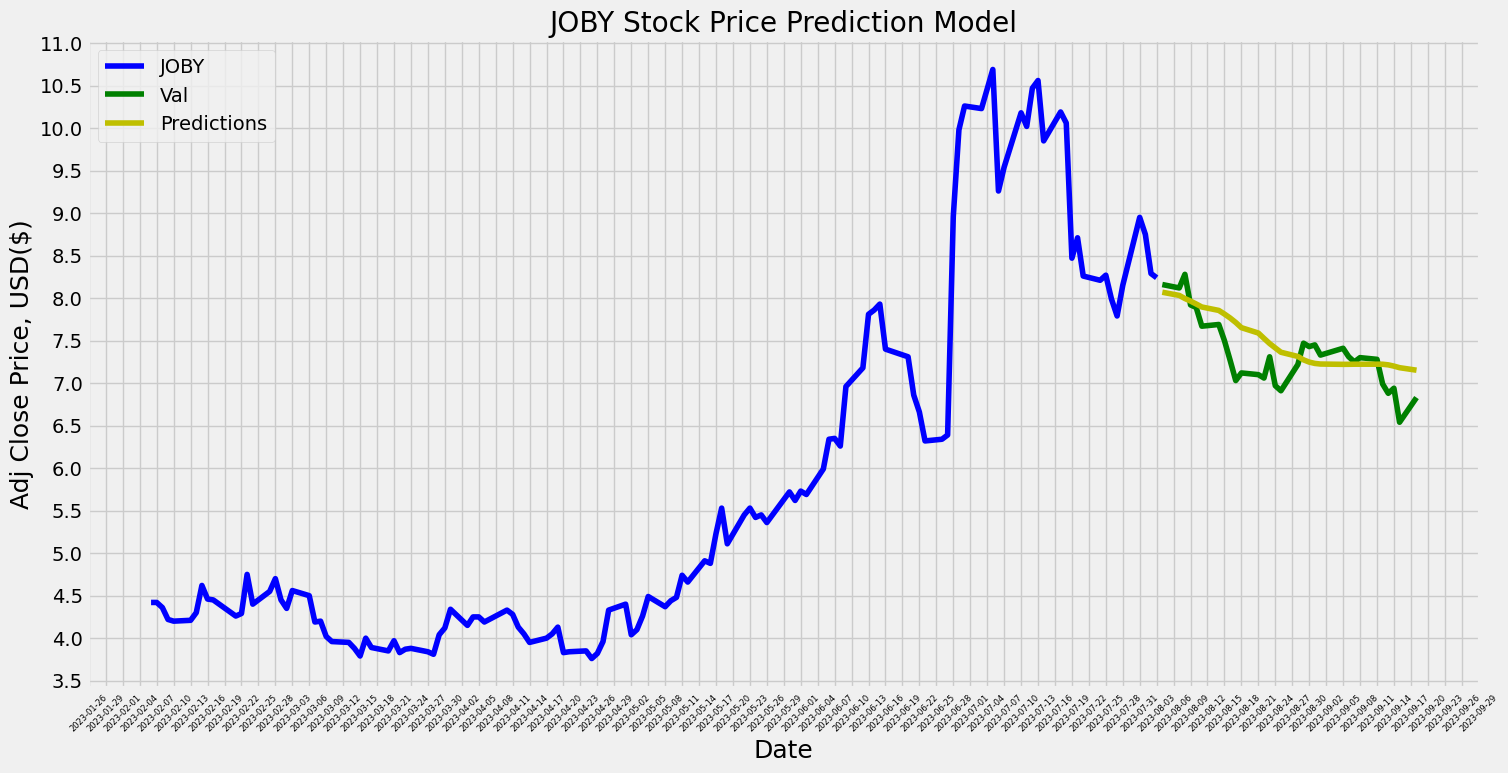

In [ ]:
from matplotlib.ticker import MultipleLocator

# Plot data
train = data[:trainlen]
valid = data[trainlen:]
valid['Predictions'] = predictions

# Visual graphic rendering
plt.figure(figsize=(16, 8))
plt.title('%s Stock Price Prediction Model' % str(tag))
plt.xlabel('Date', fontsize=18)
ax = plt.gca()  # Get the current axis

# Set ticks for every day but label every 10th day
ax.xaxis.set_major_locator(DayLocator(interval=3))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax.xaxis.set_minor_locator(DayLocator(interval=100))

# Set font size for x-axis date labels
ax.tick_params(axis='x', labelsize=6)  # Adjust the font size here (change to your desired size)

# Set y-axis tick interval to 0.5 increments
ax.yaxis.set_major_locator(MultipleLocator(0.5))

plt.xticks(rotation=45)  # Rotate the tick labels by 45 degrees
plt.ylabel('Adj Close Price, USD($)', fontsize=18)  # Was 'Close'
plt.plot(train['Adj Close'], 'b')  # Was 'Close'
plt.plot(valid['Adj Close'], 'g-')  # Was 'Close'
plt.plot(valid['Predictions'], 'y')
plt.legend([str(tag), 'Val', 'Predictions'], loc='upper left')
plt.show()


### show the valid and predicted prices

In [ ]:
valid[-60:]

,Adj Close,Predictions
Date,,
2023-08-04,8.16,8.069559
2023-08-07,8.12,8.031911
2023-08-08,8.28,7.995559
2023-08-09,7.92,7.964810
2023-08-10,7.89,7.931180
2023-08-11,7.67,7.895804
2023-08-14,7.69,7.855428
2023-08-15,7.50,7.813162
2023-08-16,7.27,7.766771


### alter predicted date to be the next day (after last day)

In [ ]:
# Convert 'end' to a datetime object
end_date = datetime.strptime(end, '%Y-%m-%d')

# Add two days to 'end_date'
pred_date = end_date + timedelta(days=0)

# Convert 'pred_date' back to a string in the 'YYYY-MM-DD' format
pred_date = pred_date.strftime('%Y-%m-%d')

print(pred_date)

2023-09-19


### predict closing price for next day

In [ ]:
# quote market stock price
quote1 = pdr.DataReader(tag,start,pred_date)

# create new data frame (df)
newdf = quote1.filter(['Adj Close']) #was close

# get the last 60-day closing price values and convert the dataframe to an array
post60 = newdf[-60:].values #tailed 60 ct. entires from close column, unique array conversion (was -60:)

# scale the data to be values to between 0 and 1
post60scaled = scaler.transform(post60)

# create emply list
testx = []

# append the past 60 days data
testx.append(post60scaled)

# convert the testx data set to a np array
testx = np.array(testx)

# reshape dataframe
testx = np.reshape(testx, (testx.shape[0], testx.shape[1],1)) # scaled post60 sample set,

# get predicted scaled price
predprice = model.predict(testx)

# undo the scaling
predprice = scaler.inverse_transform(predprice)
print(f'The predicted price for the next day, {pred_date}, is: ${predprice[0][0]:.3f}')

# Calculate the last closing price from quote_df
last_close_price = quote_df['Adj Close'].iloc[-1]  # Assuming 'Adj Close' is the column name

# print latest close price
print(f'The latest close price for the given day, {entered_end}, is: ${last_close_price:.3f}')

# Calculate the percentage difference
percentage_difference = ((predprice[0][0] - last_close_price) / last_close_price) * 100

# Check if the percentage difference is positive, negative, or zero
if percentage_difference > 0:
    direction = "positive"
elif percentage_difference < 0:
    direction = "negative"
else:
    direction = "no change"

print(f'The percentage difference from the last close price is: {percentage_difference:.2f}%, which is a {direction} change.')

[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 0s 126ms/step
The predicted price for the next day, 2023-09-19, is: $7.122
The latest close price for the given day, 2023-09-18, is: $6.830
The percentage difference from the last close price is: 4.28%, which is a positive change.


### compare to end date

In [ ]:
quote_df2 = pdr.DataReader(tag,start,end)
quote_df2

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-02-06,4.65,4.670,4.390,4.42,4.42,3110200
2023-02-07,4.46,4.480,4.210,4.42,4.42,2898700
2023-02-08,4.38,4.440,4.305,4.36,4.36,1875300
2023-02-09,4.47,4.575,4.210,4.22,4.22,2250200
2023-02-10,4.21,4.219,4.095,4.20,4.20,1599400
...,...,...,...,...,...,...
2023-09-12,7.20,7.310,6.980,6.99,6.99,3565600
2023-09-13,6.96,7.045,6.870,6.88,6.88,4684700
2023-09-14,6.90,7.000,6.780,6.94,6.94,4972100
